### 利用keras重新训练VGG16网络识别Tensorflow例子中的5种花

In [2]:
import json
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'flower/train'
validation_data_dir = 'flower/valid'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

class_count = train_generator.num_classes

label_value = [str(x) for x in train_generator.class_indices.values()]
class_label = dict(zip(label_value, train_generator.class_indices.keys()))
with open("./flower_label.json", 'w') as json_file:
    json.dump(class_label, json_file, ensure_ascii=False)


# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
print('Base Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(class_count, activation='softmax'))


# add the model on top of the convolutional base
# model.add(top_model)
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:18]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


model.summary()

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

model.save('vgg16_finetune.h5')

Found 3670 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.
Base Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______________________________________

### 验证重新训练的网络

[[  2.27510703e-19   0.00000000e+00   8.09200907e-31   1.72030014e-24
    1.00000000e+00]]
{u'1': u'dandelion', u'0': u'daisy', u'3': u'sunflowers', u'2': u'roses', u'4': u'tulips'}


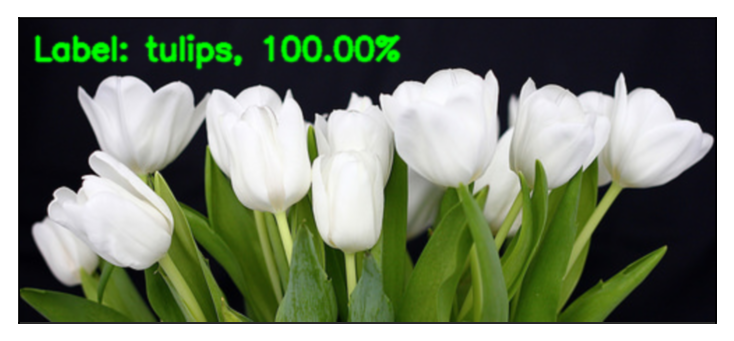

In [4]:
%matplotlib inline
import json
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import cv2
from matplotlib import pyplot as plt


def decode_prediction(preds):
    CLASS_INDEX = json.load(open('./flower_label.json'))
    print CLASS_INDEX
    for pred in preds:
        top_indices = pred.argsort()[-1:][::-1][0]
        label = CLASS_INDEX[str(top_indices)]
        prox = pred[top_indices]
    return label, prox


model = load_model('vgg16_finetune.h5')

img_path = 'tulips.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
print features

pic_label, pic_prox = decode_prediction(features)

# Label and show the image
img = cv2.imread('tulips.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
cv2.putText(img, "Label: {}, {:.2f}%".format(pic_label, pic_prox * 100), 
            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 2, cv2.LINE_AA)
plt.figure(dpi=150)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
